## Imports

In [475]:
import os, glob
import ast
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch as th
import torch.nn as nn
import dgl

from radon.complexity import cc_visit
from radon.metrics import mi_compute
from radon.metrics import h_visit_ast
from radon.visitors import ComplexityVisitor
from radon.visitors import HalsteadVisitor
from radon.raw import analyze
from radon.metrics import mi_visit

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

## Loading Dataset

In [3]:
with open("ideas.md") as f:
    ideas = f.readlines()
# get lines starting with - or =- and remove the - or =-
ideas = [i.strip()[1:] for i in ideas if i.startswith("-") or i.startswith("=-")]
len(ideas)

131

## Helper Functions

In [878]:
def generate_ast_graph(node):
    """
    Recursively generate a networkx tree graph of an AST using a custom NodeVisitor class,
    retaining the order of the visit.
    """
    class Visitor(ast.NodeVisitor):
        def __init__(self):
            self.graph = nx.DiGraph()
            self.counter = 0
            self.parent = None
        
        def generic_visit(self, node):
            node_id = self.counter
            self.counter += 1
            self.graph.add_node(node_id, label=type(node).__name__)
            if self.parent is not None:
                self.graph.add_edge(self.parent, node_id)
            self.parent = node_id
            ast.NodeVisitor.generic_visit(self, node)
            self.parent = node_id
    
    visitor = Visitor()
    visitor.visit(node)
    return visitor.graph

def plot_graph(graph, label=0, ax=None):
    # Draw graph
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Create the title for the ax, not a new figure
    if ax is not None:
        ax.set_title(label, fontsize=12)
    else:
        plt.title(label, fontsize=12)
    nx.draw(
        graph,
        labels=nx.get_node_attributes(graph, "label"),
        font_weight="bold",
        node_size=200,
        node_color="skyblue",
        pos=pos,
        font_size=5,
        width=3,
        edge_color="black",
        arrowsize=5,
        arrowstyle="-|>",
        arrows=True,
        alpha=0.5,
        linewidths=1.5,
        style="dashed",
        ax=ax,  # draw on the passed in ax
    )

def get_py_files(folder_to_crawl):
    "folder_to_crawl: '3.5turbo' or 'humanCode'"
    CWD = os.getcwd()
    CODE_DIR = os.path.join(CWD, folder_to_crawl)
    files = glob.glob(os.path.join(CODE_DIR, '**/*.py'), recursive=True)
    Code_dirs = [f.split(folder_to_crawl)[1].split("/") for f in files]
    Code_df = pd.DataFrame(Code_dirs, columns=['Preamble', 'Category', 'Subcategory', 'Filename'], index = None)
    return Code_df

def get_ast_graphs(df, folder_to_crawl):
    ast_graph_df = df.copy()
    CWD = os.getcwd()
    ast_graph_df["AST"] = None
    ast_graph_df["Graph"] = None
    for i, row in enumerate(ast_graph_df.iterrows()):
        row = os.path.join(row[1]['Category'], row[1]['Subcategory'], row[1]['Filename'])
        PATH = os.path.join(CWD, folder_to_crawl, row)
        with open(PATH) as f:
            code = f.readlines()
        code_ast = ast.parse("".join(code))
        ast_graph_df["AST"].loc[i] = code_ast
        ast_graph_df["Graph"].loc[i] = generate_ast_graph(code_ast)
    return ast_graph_df

def get_metrics(df, folder_to_crawl):
    metrics_graph_df = df.copy()
    CWD = os.getcwd()
    metrics_graph_df['Cyclomatic_Complexity'] = None
    metrics_graph_df['Halstead_Difficulty'] = None
    metrics_graph_df['Halstead_Effort'] = None
    metrics_graph_df['Halstead_Volume'] = None
    metrics_graph_df['Halstead_Time'] = None
    metrics_graph_df['Halstead_Bugs'] = None
    metrics_graph_df['SLoC'] = None
    metrics_graph_df["Logical_SLoC"] = None
    metrics_graph_df['Number_of_Functions'] = None
    metrics_graph_df['Number_of_Classes'] = None
    metrics_graph_df['Number_of_Statements'] = None
    metrics_graph_df['Number_of_Comments'] = None
    metrics_graph_df['Diff_SLoC_LLoC'] = None
    metrics_graph_df['Maintainability_Index'] = None
    for i, row in enumerate(metrics_graph_df.iterrows()):
        row = os.path.join(row[1]['Category'], row[1]['Subcategory'], row[1]['Filename'])
        PATH = os.path.join(CWD, folder_to_crawl, row)
        with open(PATH) as f:
            code = f.readlines()
        ast_code = ast.parse("".join(code))
        complexity = ComplexityVisitor.from_code(ast_code)
        metrics_graph_df['Cyclomatic_Complexity'].iloc[i] = complexity.total_complexity
        #metrics_graph_df['SLoC'].loc[i] = analyze(code).sloc #complexity[0].nloc#
        #hal = HalsteadVisitor.from_code("".join(code))
        hal_visit = h_visit_ast(ast.parse("".join(code)))
        hal = hal_visit[0]
        
        metrics_graph_df['Halstead_Difficulty'].iloc[i] = hal.difficulty
        metrics_graph_df['Halstead_Effort'].iloc[i] = hal.effort
        metrics_graph_df['Halstead_Volume'].iloc[i] = hal.volume
        metrics_graph_df['Halstead_Time'].iloc[i] = hal.time
        metrics_graph_df['Halstead_Bugs'].iloc[i] = hal.bugs
        
        metrics_graph_df['SLoC'].iloc[i] = analyze("".join(code)).sloc
        metrics_graph_df["Logical_SLoC"].iloc[i] = analyze("".join(code)).lloc
        metrics_graph_df['Diff_SLoC_LLoC'].iloc[i] = abs(analyze("".join(code)).sloc - analyze("".join(code)).lloc)

        metrics_graph_df['Number_of_Functions'].iloc[i] = len(hal_visit[1])#analyze(code).functions
        metrics_graph_df['Number_of_Classes'].iloc[i] = len(complexity.classes)#analyze(code).classes
        metrics_graph_df['Number_of_Statements'].iloc[i] = analyze("".join(code)).loc
        metrics_graph_df['Number_of_Comments'].iloc[i] = analyze("".join(code)).comments
        metrics_graph_df['Maintainability_Index'].iloc[i] = mi_visit("".join(code), True)      
        # complexity = cc_visit("".join(code))
        # try:
        #     maintain_index = mi_compute(hal.volume, complexity[0].complexity, analyze("".join(code)).sloc, analyze("".join(code)).comments)
        #     metrics_graph_df['Maintainability_Index'].loc[i] = maintain_index
        # except:
        #     print(str(PATH.split("/")[6:]))
        #     metrics_graph_df['Maintainability Index'].loc[i] = 0
    return metrics_graph_df
  # label for a list of nodes

def get_label(graph, nodes):
    return [graph.nodes[x]["label"] for x in nodes]

def get_traversal_labels(graph, traversal= nx.dfs_postorder_nodes):
    traversed_labels = get_label(graph, list(traversal(graph, 0)))
    return traversed_labels

def get_traversed_seqs(total_unique_nodes, padded_graphs):
    traversed_seq_indexes = []
    for i, graph in tqdm(enumerate(padded_graphs), total=len(padded_graphs)):
        traversed_seq = list(get_traversal_labels(graph, nx.dfs_postorder_nodes))
        if len(traversed_seq) < 2:
            print(f"This one has less than 2 nodes")
            continue
        traversed_seq_indexes.append([total_unique_nodes.index(word) for word in traversed_seq])
    return traversed_seq_indexes

def pad_trarsed_trees(traversed_seq_indexes, max_len=1000):
    pad_traversed_seq_indexes_array = np.zeros((len(traversed_seq_indexes), max_len))
    for i, seq in enumerate(traversed_seq_indexes):
        if len(seq) >= max_len:
            seq = seq[:max_len]
        else:
            seq = seq + [0] * (max_len - len(seq))
        pad_traversed_seq_indexes_array[i] = np.array(seq)
    return pad_traversed_seq_indexes_array

def get_all_nodes(Code_df):
    nodes_corpus = []
    for graph in Code_df['Graph'].values:
        nodes_corpus.extend(get_label(graph,graph.nodes()))

    return nodes_corpus

## Get the py files

In [879]:
ChatGPT_df = get_py_files('3.5turbo')
humanCode_df = get_py_files('humanCode')
# ChatGPT_df = get_ast_graphs(ChatGPT_df, "3.5turbo")
# humanCode_df = get_ast_graphs(humanCode_df, "humanCode")
ChatGPT_df = get_metrics(ChatGPT_df, "3.5turbo")
humanCode_df = get_metrics(humanCode_df, "humanCode")

#humanCode_df[humanCode_df.Diff_SLoC_LLoC == humanCode_df.Diff_SLoC_LLoC.max()]

In [664]:
ChatGPT_df["Code"] = "ChatGPT"
humanCode_df["Code"] = "Human"
ChatGPT_df = ChatGPT_df[["Code", "Category", "Subcategory", "Filename"]]
humanCode_df = humanCode_df[["Code", "Category", "Subcategory", "Filename"]]
full_df = pd.concat([ChatGPT_df, humanCode_df], axis=0)

In [644]:
full_df = pd.read_csv("Full_dataset.csv")

In [377]:
# Finds the distance between the filenames of the two datasets using Levenshtein distance to see if there are any mismatches
import Levenshtein
filenames_df = pd.DataFrame(pd.concat([ChatGPT_df["Filename"].rename("Filename_ChatGPT"), humanCode_df["Filename"].rename("Filename_humanCode")], axis=1))
filenames_df["Levenshtein_Distance"] = None
for i, row in enumerate(filenames_df.iterrows()):
    filenames_df["Levenshtein_Distance"].loc[i] = Levenshtein.distance(row[1]["Filename_ChatGPT"], row[1]["Filename_humanCode"])
# If there are mismatches this will show them
filenames_df[filenames_df["Levenshtein_Distance"] > 0]

Empty DataFrame
Columns: [Filename_ChatGPT, Filename_humanCode, Levenshtein_Distance]
Index: []

## Visual Analysis

In [ ]:
import pandas as pd
import plotly
import chart_studio.plotly as py

def genSankey(df, cat_cols=[], value_cols='', title='Sankey Diagram'):
    # Maximum of 6 value cols -> 6 colors
    colorPalette = ['#ee8f8f', '#87b787', '#FFE873', '#FFD43B', '#646464', 'yellow']  # Added 'yellow' to the palette
    labelList = []
    colorNumList = []
    
    for catCol in cat_cols:
        labelListTemp = list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp

    # Remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))

    # Define colors based on the number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]] * colorNum

    # Transform df into a source-target pair
    for i in range(len(cat_cols) - 1):
        if i == 0:
            sourceTargetDf = df[[cat_cols[i], cat_cols[i + 1], value_cols]]
            sourceTargetDf.columns = ['source', 'target', 'count']
        else:
            tempDf = df[[cat_cols[i], cat_cols[i + 1], value_cols]]
            tempDf.columns = ['source', 'target', 'count']
            sourceTargetDf = pd.concat([sourceTargetDf, tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source', 'target']).agg({'count': 'sum'}).reset_index()

    # Add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))

    # Creating the Sankey diagram
    data = dict(
        type='sankey',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(
                color="black",
                width=0.5
            ),
            label=labelList,
            text=sourceTargetDf['count'].astype(str),
            color=colorList
        ),
        link=dict(
            source=sourceTargetDf['sourceID'],
            target=sourceTargetDf['targetID'],
            value=sourceTargetDf['count'],
            label=sourceTargetDf['count'].astype(str),  # Show counts as labels
            text=sourceTargetDf['count'].astype(str),   # Show counts as text on the links
            
        )
    )

    layout = dict(
        title=title,
        font=dict(
            size=20
        )
        
    )

    fig = dict(data=[data], layout=layout)
    return fig

if __name__ == "__main__":
    full_df = pd.read_csv("Full_dataset.csv")
    # Generate the Sankey diagram figure
    fig = genSankey(full_df, cat_cols=full_df.columns[:-1], value_cols='Code', title='Dataset Sankey Plot')
    plotly.offline.plot(fig, validate=False)


/tmp/ipykernel_3365642/3473948524.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_visuals.hist(bins=bins, xlabelsize=x_size, ylabelsize=y_size, xrot=x_rot, yrot=y_rot, ax=ax)


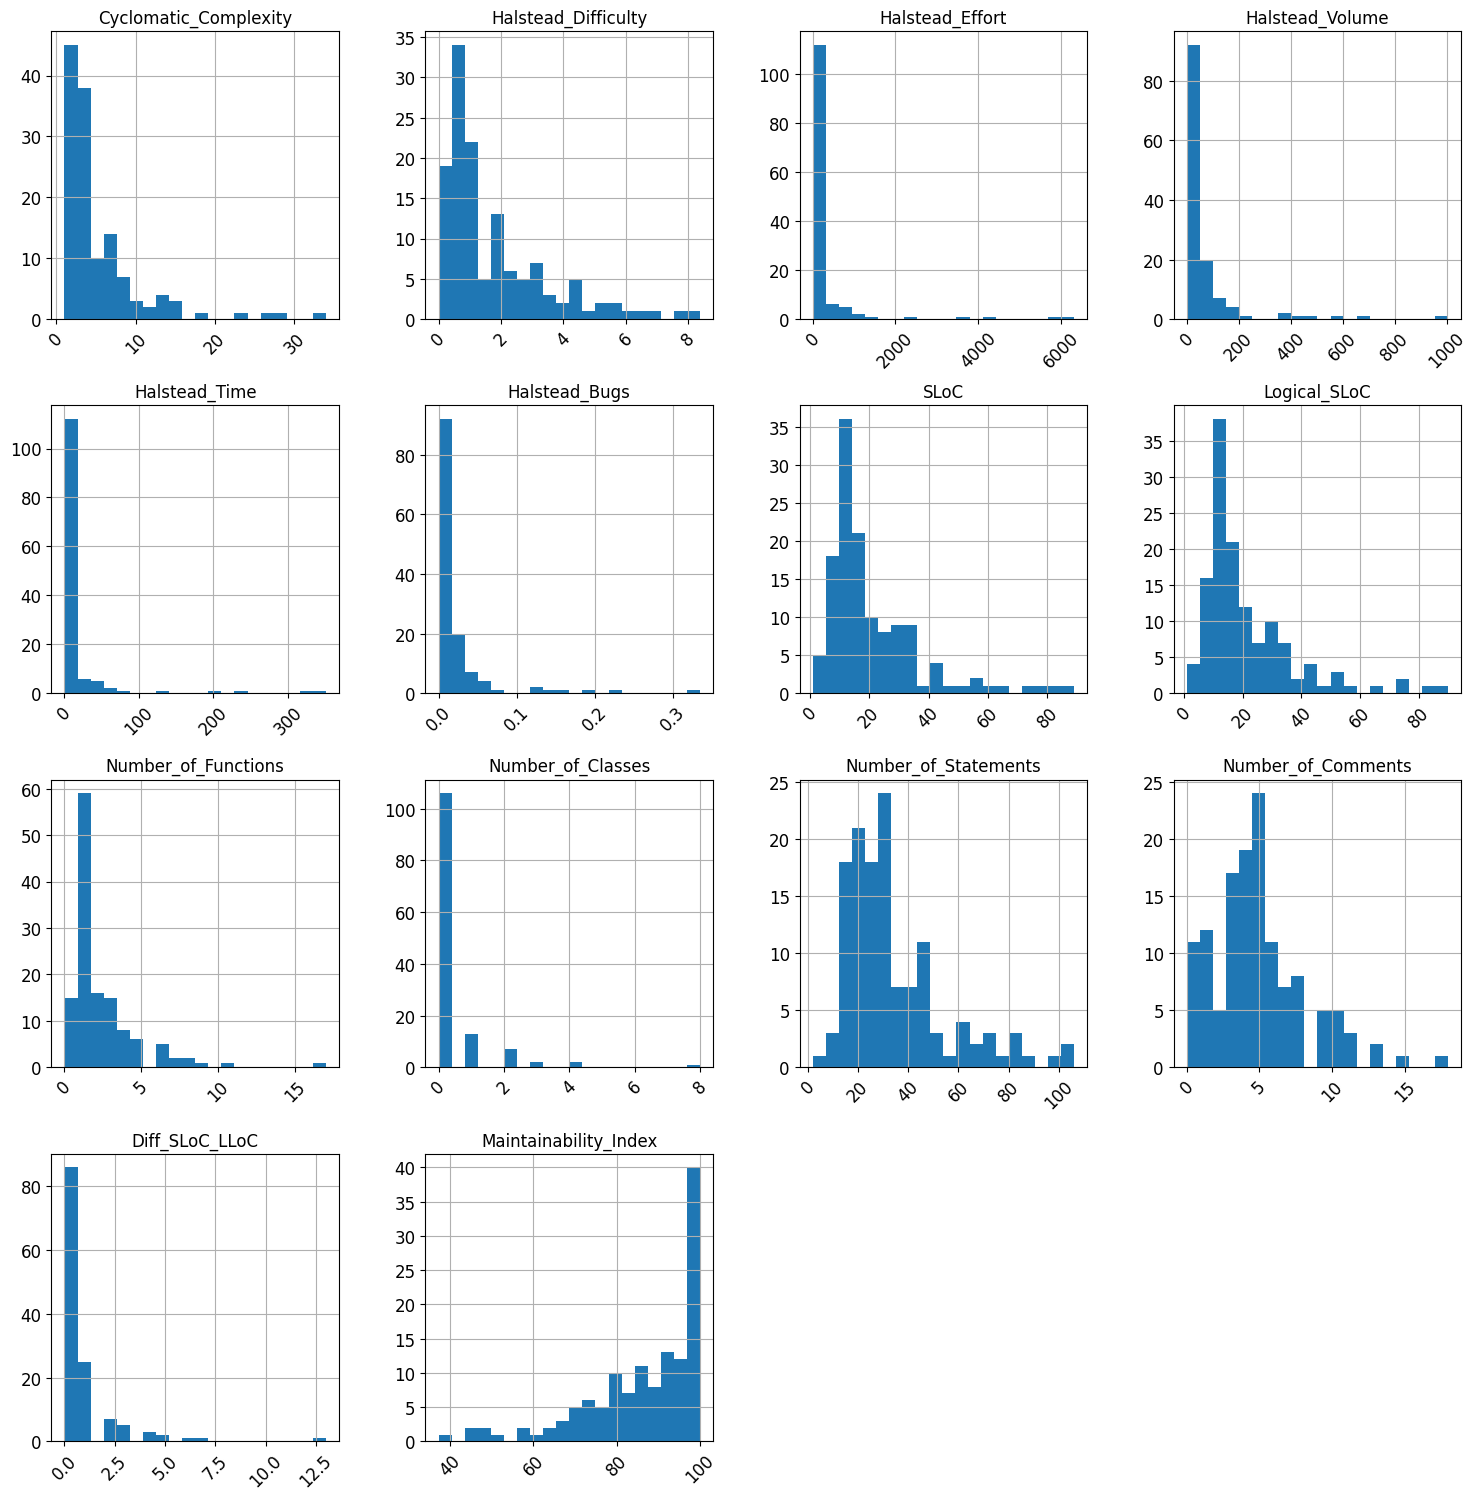

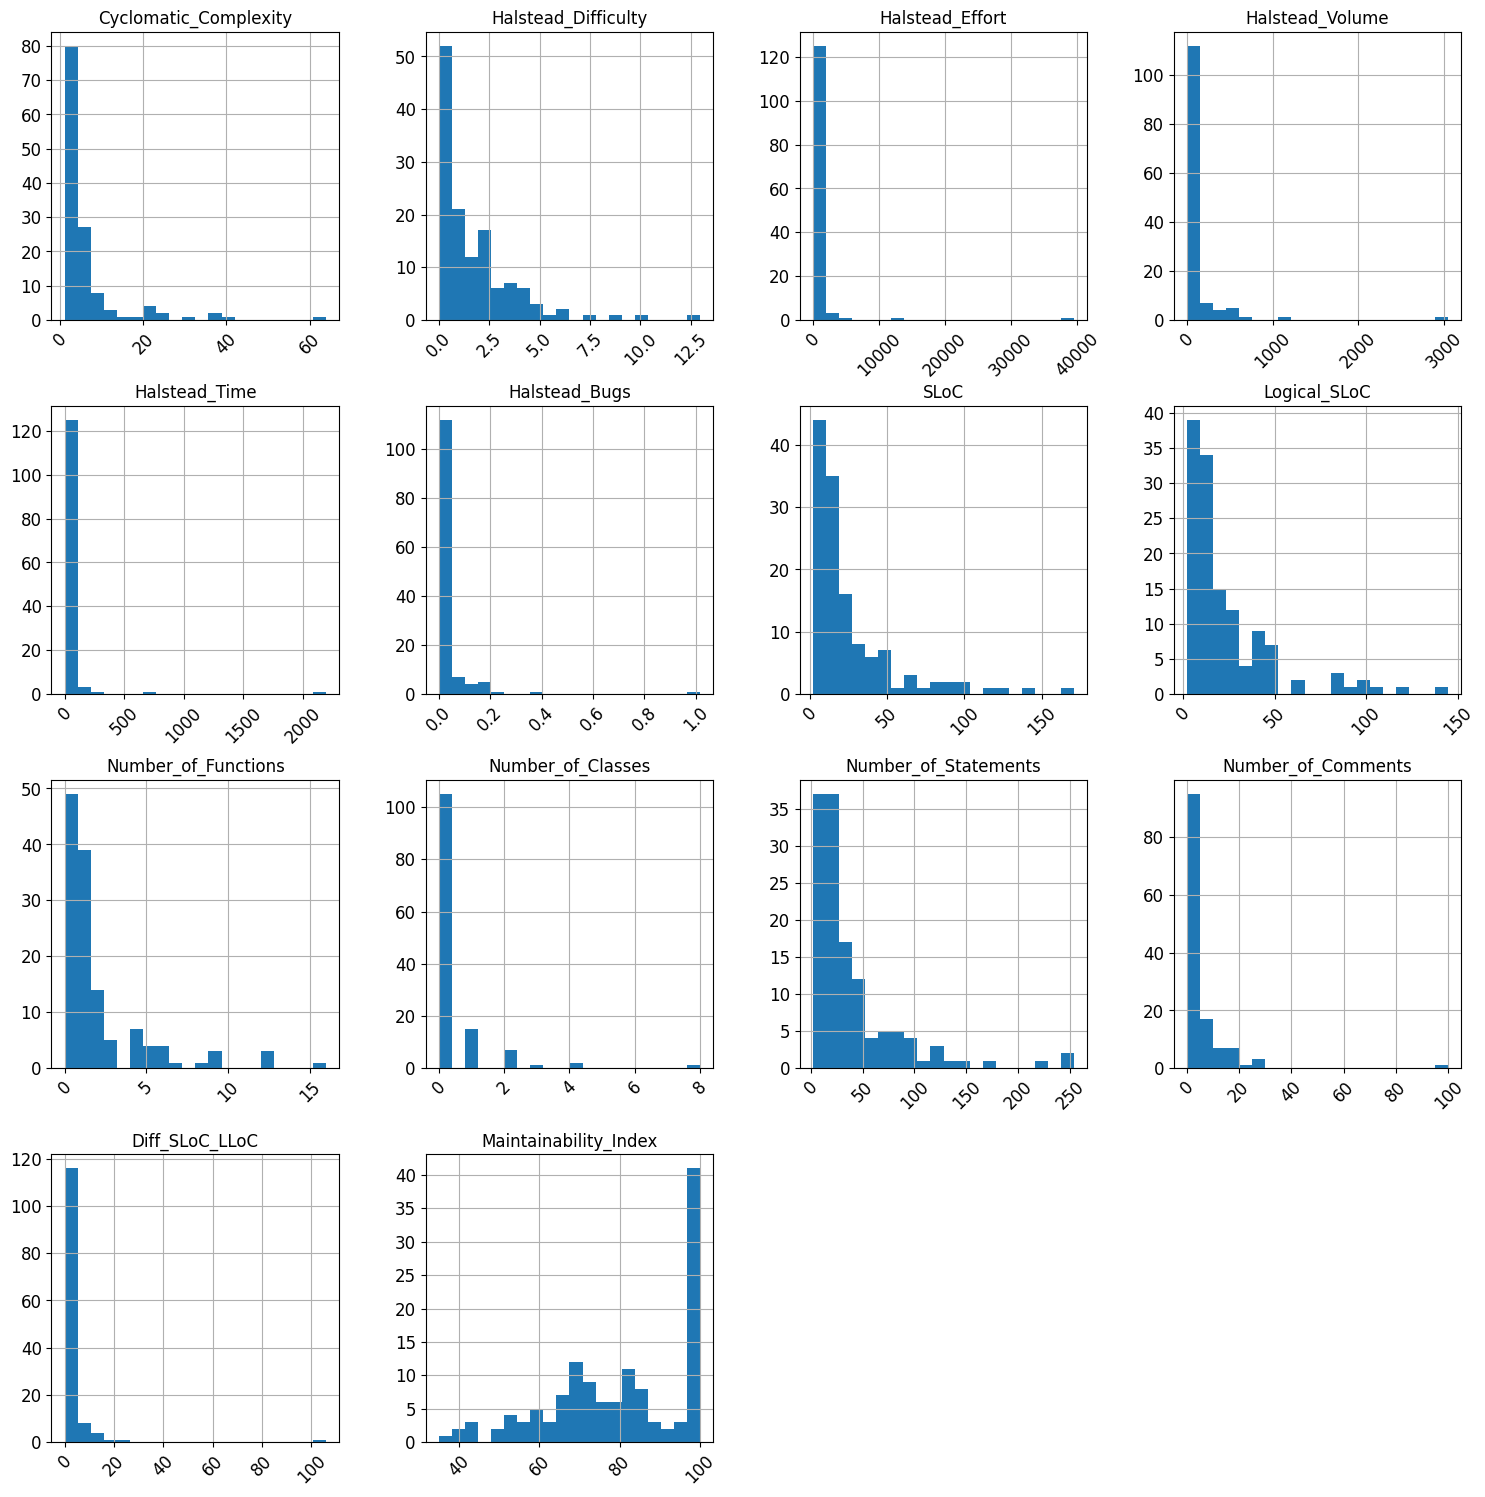

In [487]:
def get_hist(df_visuals, export_path, file_name, fig_size=(15, 15), bins=20, x_size=12, y_size=12, x_rot=45, y_rot=0,margin=0.03, dpi=600):
    fig, ax = plt.subplots(figsize=fig_size)
    df_visuals.hist(bins=bins, xlabelsize=x_size, ylabelsize=y_size, xrot=x_rot, yrot=y_rot, ax=ax)
    plt.subplots_adjust(left=margin, right=1-margin, bottom=margin, top=1-margin)
    os.makedirs(export_path, exist_ok=True)
    fig.savefig(os.path.join(export_path, file_name), dpi=dpi)
    

df_visuals = ChatGPT_df[ChatGPT_df.columns[4:]].astype(float)
get_hist(
    df_visuals,
    export_path=f"{os.getcwd()}/analysis/metrics/box_wiskers",
    file_name="ChatGPT_metrics_hist.png"
)

df_chatgpt_visuals = humanCode_df[humanCode_df.columns[4:]].astype(float)
get_hist(
    df_visuals,
    export_path=f"{os.getcwd()}/analysis/metrics/box_wiskers",
    file_name="humanCode_metrics_hist.png"
)



In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Function to create and save the overlaid histograms
def get_hist(df_chatgpt_visuals, df_human_visuals, export_path, file_name, fig_size=(15, 15), bins=20, x_size=12, y_size=12, x_rot=45, y_rot=0, margin=0.03, dpi=600):
    # Get the number of metrics
    num_metrics = len(df_visuals.columns)
    
    # Calculate the number of rows and columns for subplots
    num_rows = num_metrics // 2 + num_metrics % 2
    num_cols = 2 if num_metrics > 1 else 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=fig_size)
    axes = axes.flatten()
    
    for i, column in enumerate(df_visuals.columns):
        ax = axes[i]
        
        # Create histograms for the current metric and overlay them
        sns.kdeplot(df_chatgpt_visuals[column], ax=ax, label="ChatGPT", color="red")
        sns.kdeplot(df_human_visuals[column], ax=ax, label="Human", color="green")
        
        ax.set_title(column)  # Set the title as the metric name
        ax.legend()  # Add a legend to distinguish dataframes
    
    # Remove any empty subplots
    for i in range(num_metrics, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    os.makedirs(export_path, exist_ok=True)
    fig.savefig(os.path.join(export_path, file_name), dpi=dpi)


# Create and save the overlaid histograms in separate subplots
get_hist(
    ChatGPT_df[ChatGPT_df.columns[4:]],
    humanCode_df[humanCode_df.columns[4:]],
    export_path=f"{os.getcwd()}/analysis/metrics/box_wiskers",
    file_name="ChatGPT_vs_humanCode_metrics_hist.png"
)


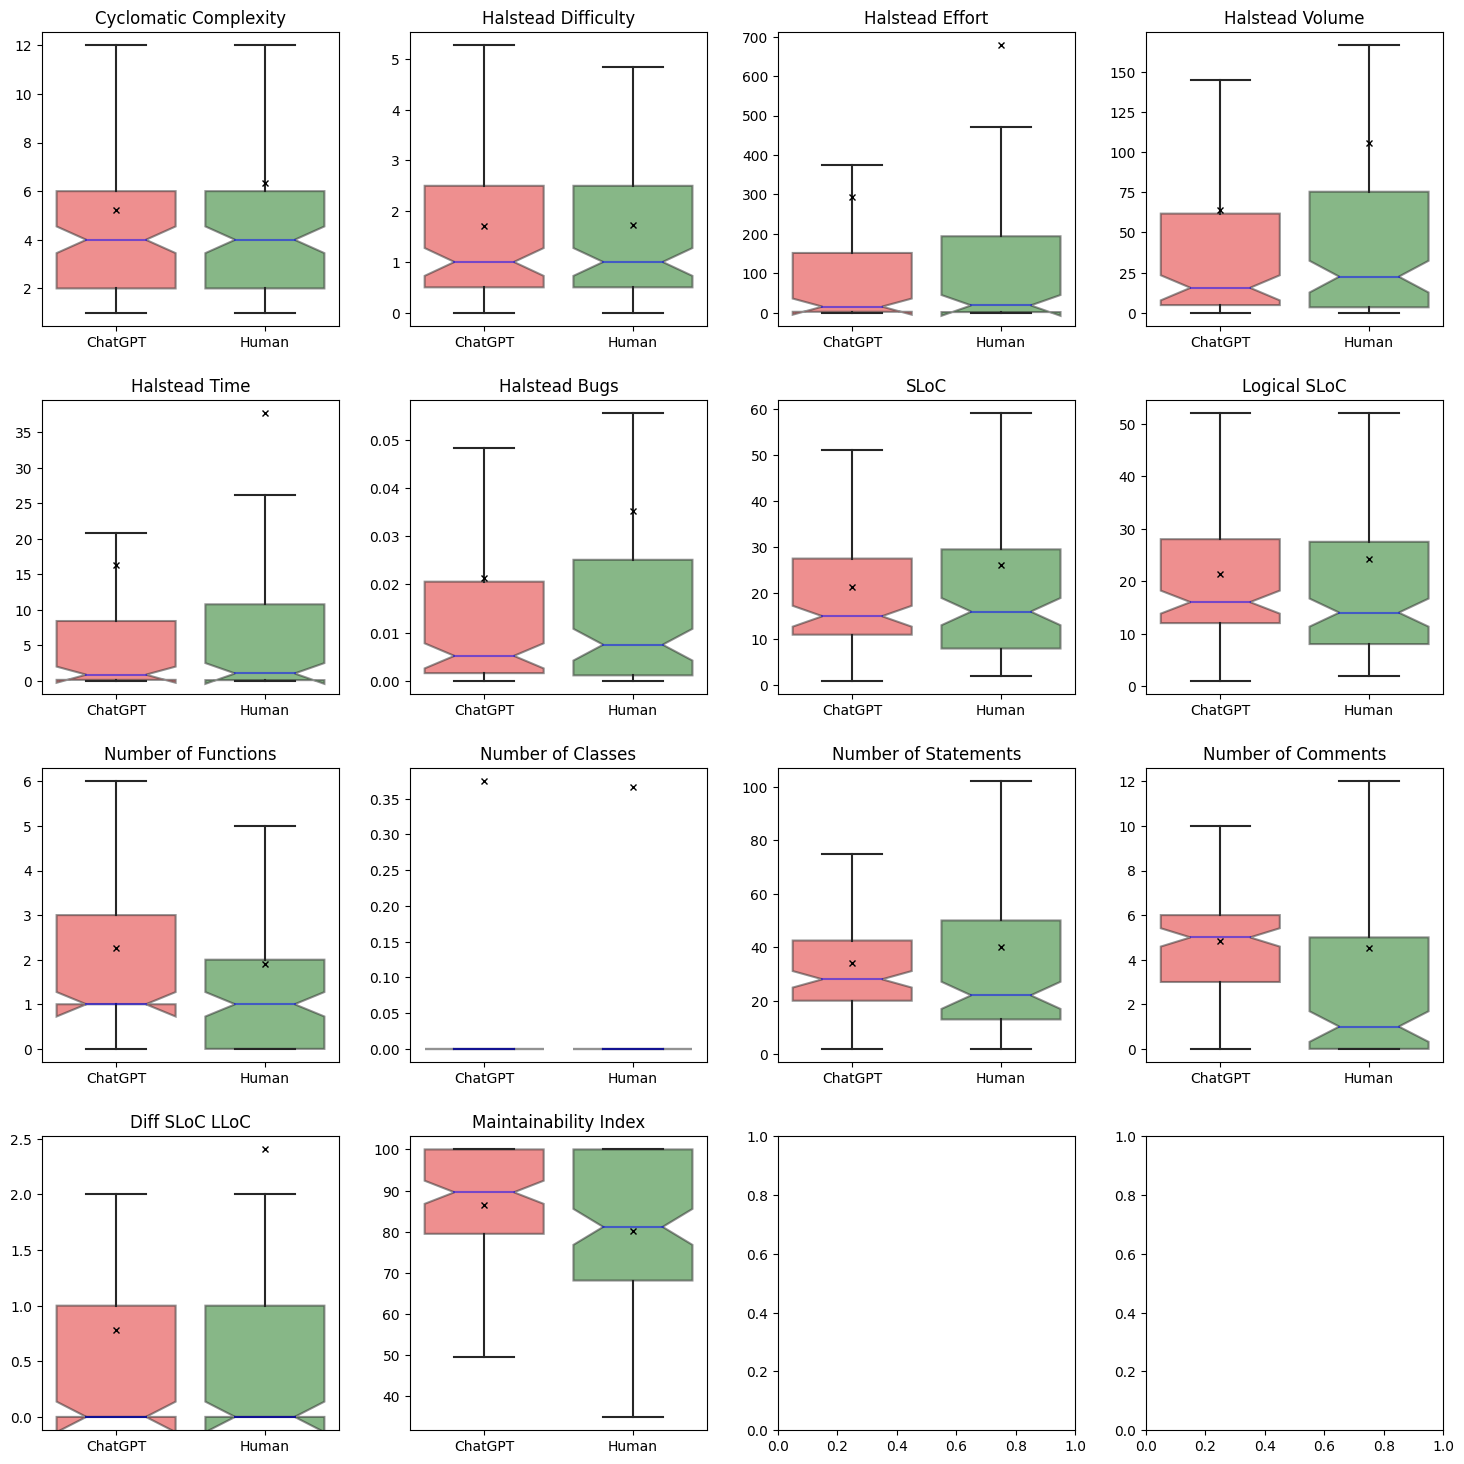

In [610]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_boxplot(df_chatgpt_visuals, df_human_visuals, export_path, file_name, fig_size=(15, 15), dpi=600):
    # Get the number of metrics
    num_metrics = len(df_chatgpt_visuals.columns)
    
    # Calculate the number of rows and columns for subplots
    num_rows = 4
    num_cols = 4 if num_metrics > 1 else 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=fig_size)
    
    # Define colors for ChatGPT and Human
    chatgpt_color = 'red'
    human_color = 'green'
    
    for i, (chatGPT_column, human_column) in enumerate(zip(df_chatgpt_visuals.columns, df_human_visuals.columns)):
        ax = axes[i // num_cols, i % num_cols]
        
        # Box plot for ChatGPT with transparency
        box_colors = ["red", "green"]
        combined_column = pd.concat([df_chatgpt_visuals[chatGPT_column], df_human_visuals[human_column]], axis=1)
        sns.boxplot(data=combined_column, ax=ax, showfliers=False, notch=True, showmeans=True, palette=box_colors, boxprops=dict(alpha=0.5), medianprops={"color": "blue", "alpha": 0.5}, meanprops={"marker":"x","markerfacecolor":"black", "markeredgecolor":"black", "markersize":"5"})
        ax.set_xticklabels(["ChatGPT", "Human"])
        
        ax.set_title(chatGPT_column[8:].replace("_", " "))  # Set the title as the metric name
        
    # Add a blank subplot between the third and fourth subplots for center alignment
    if num_metrics % num_cols == 3:
        blank_ax = fig.add_subplot(num_rows, num_cols, num_metrics + 1, frame_on=False)
        blank_ax.axis('off')
    
    # Remove any empty subplots
    for i in range(num_metrics, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout(pad=2.0)  # Adjust pad for proper center alignment
    os.makedirs(export_path, exist_ok=True)
    fig.savefig(os.path.join(export_path, file_name), dpi=dpi)

chatgpt_visual_df = ChatGPT_df[ChatGPT_df.columns[4:]].astype(float).add_prefix('ChatGPT_')
humanCode_visual_df = humanCode_df[humanCode_df.columns[4:]].astype(float).add_prefix('Human_')

get_boxplot(
    chatgpt_visual_df,
    humanCode_visual_df,
    export_path=f"{os.getcwd()}/analysis/metrics/box_wiskers",
    file_name="ChatGPT_vs_humanCode_metrics_boxplot.png"
)


In [692]:
ChatGPT_df_spider_df = ChatGPT_df.groupby(['Category']).mean().reset_index()
humanCode_df_spider_df = humanCode_df.groupby(['Category']).mean().reset_index()

/tmp/ipykernel_3365642/3544877257.py:1: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.

/tmp/ipykernel_3365642/3544877257.py:2: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.



In [880]:
pd.concat([ChatGPT_df_spider_df.iloc[:,1].rename("ChatGPT"), humanCode_df_spider_df.iloc[:,1].rename("Human")], axis=1).set_index(ChatGPT_df_spider_df["Category"]).

SyntaxError: invalid syntax (165897687.py, line 1)

In [727]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

index = 1
columns = ChatGPT_df_spider_df.columns
# Create a DataFrame from the data
df = pd.concat([ChatGPT_df_spider_df.iloc[:,index].rename("ChatGPT"), humanCode_df_spider_df.iloc[:,index].rename("Human")], axis=1).set_index(ChatGPT_df_spider_df["Category"])
df =pd.concat([df, df.iloc[[0]]])

# Create a spider plot
num_vars = len(df)-1
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
print(angles)
angles += angles[:1]  # Ensure the plot is closed
print(angles)

# Create subplots
fig, ax = plt.subplots(subplot_kw={'polar': True}, figsize=(8, 8))

print(len(angles), len(df['ChatGPT']))
# Plot means
# ax.fill(angles, df['ChatGPT'], 'red', alpha=0.5, label='ChatGPT')
# ax.fill(angles, df['Human'], 'green', alpha=0.5, label='Human')

# # Plot standard deviations as dashed lines
ax.plot(angles, df['ChatGPT'], 'r--', linewidth=1, label='ChatGPT')
ax.plot(angles, df['Human'], 'g-', linewidth=1, label='Human')

# # Fill the area inside the lines
# ax.fill(angles, df['ChatGPT_Std'], 'red', alpha=0.5)
# ax.fill(angles, df['Human_Std'], 'green', alpha=0.5)

# Set axis labels
ax.set_xticks(angles[:])
ax.set_xticklabels(df.index)

# Add legend and title
ax.legend(loc='upper right')
plt.title(columns[index])

# Show the plot
plt.show()


[0.0, 1.2566370614359172, 2.5132741228718345, 3.7699111843077517, 5.026548245743669]
[0.0, 1.2566370614359172, 2.5132741228718345, 3.7699111843077517, 5.026548245743669, 0.0]


ValueError: Number of rows must be a positive integer, not (2, 2)

<Figure size 800x800 with 0 Axes>

In [764]:
def return_initials(word, seperator):
    return ''.join([w[0].upper() for w in list(word.split(seperator))])

In [915]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.text import Text

# Assuming you have ChatGPT_df_spider_df and humanCode_df_spider_df already defined

# Get the columns you want to plot
columns_to_plot = ChatGPT_df_spider_df.columns[1:]

# Define the number of rows and columns for the grid
num_rows = 3  # You can adjust this as needed
num_cols = 5  # You can adjust this as needed

# Create a spider plot for each column
fig, axes = plt.subplots(num_rows, num_cols,subplot_kw={'polar': True}, figsize=(15, 10), dpi=600)

# Flatten the axes array if needed
axes = axes.flatten()
index_names = [return_initials(word, "-") for word in list(df.index)]
# Lower font size
for index, column in enumerate(columns_to_plot):
    # Create a DataFrame for the current column
    df = pd.concat([
        ChatGPT_df_spider_df.iloc[:, index + 1].rename("ChatGPT"),
        humanCode_df_spider_df.iloc[:, index + 1].rename("Human")
    ], axis=1).set_index(ChatGPT_df_spider_df["Category"])
    df =pd.concat([df, df.iloc[[0]]])
    # Create spider plot
    num_vars = len(df)-1
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Ensure the plot is closed
    
    # Plot means
    axes[index].plot(angles, df['ChatGPT'], 'r--', linewidth=1, label='ChatGPT', marker='o', markersize=3)
    axes[index].plot(angles, df['Human'], 'g-', linewidth=1, label='Human', marker='o', markersize=3)
    # Set axis labels
    # Limit the number of ticks to 
    y_chatgpt = df['ChatGPT'].tolist()
    y_human = df['Human'].tolist()
    y_ticks = np.unique(y_chatgpt + y_human).tolist()
    min_y = min(y_ticks)
    max_y = max(y_ticks)
    if index == 13:
        y_ticks = np.linspace(1, max_y, 3).tolist()
        axes[index].set_yticks(y_ticks)
    else:
        y_ticks = np.linspace(min_y, max_y, 3).tolist()
        axes[index].set_yticks(y_ticks)
    # Set yticks size and color
    axes[index].tick_params(axis='y', labelsize=8, labelcolor='black')
    axes[index].set_xticklabels(index_names)
    # Add legend and title
    axes[7].legend(loc='upper right')
    axes[index].set_title(column.replace("_", " "))

plt.tight_layout()
plt.savefig("./analysis/metrics/box_wiskers/spider_plot_each_category.png", dpi=1000)
plt.show()


/tmp/ipykernel_3365642/3576871727.py:52: UserWarning:

FixedFormatter should only be used together with FixedLocator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_3365642/3576871727.py:52: UserWarning:

FixedFormatter should only be used together with FixedLocator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_3365642/3576871727.py:52: UserWarning:

FixedFormatter should only be used together with FixedLocator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_3365642/3576871727.py:52: UserWarning:

FixedFormatter should only be used together with FixedLocator

No artists with labels found to put in legend.  Note that

## Train and Test Split

In [816]:
# Split the rows grouped by Category into train and test
def get_test_train_indexes(df):
    train_indexes = []
    test_indexes = []
    train_indexes = df.groupby(['Category']).apply(lambda x: x.sample(frac=0.8)).index
    test_indexes = df.drop([x[1] for x in train_indexes]).index
    train_indexes = [x[1] for x in train_indexes]
    test_indexes = [x for x in test_indexes]
    return train_indexes, test_indexes

ChatGPT_train_indexes, ChatGPT_test_indexes = get_test_train_indexes(ChatGPT_df)
humanCode_train_indexes, humanCode_test_indexes = get_test_train_indexes(humanCode_df)

train_ChatGPT_ast_graph_df = ChatGPT_df.loc[ChatGPT_train_indexes]
test_ChatGPT_ast_graph_df = ChatGPT_df.loc[ChatGPT_test_indexes]

train_humanCode_ast_graph_df = humanCode_df.loc[humanCode_train_indexes]
test_humanCode_ast_graph_df = humanCode_df.loc[humanCode_test_indexes]

# Check if size make sense
print(f"Test {len(test_ChatGPT_ast_graph_df)} + Train: {len(train_ChatGPT_ast_graph_df)} == Total: {len(ChatGPT_df)} => {len(test_humanCode_ast_graph_df) + len(train_humanCode_ast_graph_df) == len(humanCode_df)}")
print(f"Test: {len(test_humanCode_ast_graph_df)} + Train: {len(train_humanCode_ast_graph_df)} == Total: {len(humanCode_df)} => {len(test_humanCode_ast_graph_df) + len(train_humanCode_ast_graph_df) == len(humanCode_df)}")

Test 26 + Train: 105 == Total: 131 => True
Test: 26 + Train: 105 == Total: 131 => True


In [817]:
select_columns = list(train_ChatGPT_ast_graph_df.columns)[4:]
#select_columns = ["Graph"]

train_GPT_data = train_ChatGPT_ast_graph_df[select_columns]
test_GPT_data = test_ChatGPT_ast_graph_df[select_columns]

train_GPT_keys = train_ChatGPT_ast_graph_df["Filename"].values
test_GPT_keys = test_ChatGPT_ast_graph_df["Filename"].values

train_human_data = train_humanCode_ast_graph_df[select_columns]
test_human_data = test_humanCode_ast_graph_df[select_columns]

train_human_keys = train_humanCode_ast_graph_df["Filename"].values
test_human_keys = test_humanCode_ast_graph_df["Filename"].values

In [818]:
train_data = pd.concat([train_GPT_data, train_human_data], ignore_index=True)
test_data = pd.concat([test_GPT_data, test_human_data], ignore_index=True)
train_keys = train_GPT_keys.tolist() + train_human_keys.tolist()
test_keys = test_GPT_keys.tolist() + test_human_keys.tolist()


train_labels_GTP = np.zeros(len(train_GPT_keys))
train_labels_human = np.ones(len(train_human_keys))
train_labels = train_labels_GTP.tolist() + train_labels_human.tolist()

test_labels_GTP = np.zeros(len(test_GPT_keys))
test_labels_human = np.ones(len(test_human_keys))
test_labels = test_labels_GTP.tolist() + test_labels_human.tolist()


In [819]:
# Check if there are dublicates in the keys
print("If duplicates in keys (filenames) these pairs should not match")
print(((len(train_GPT_keys), len(np.unique(train_GPT_keys)))), ((len(train_human_keys), len(np.unique(train_human_keys)))))
print((len(train_human_keys), len(np.unique(train_human_keys))), (len(train_GPT_keys), len(np.unique(train_GPT_keys))))

# print("Trainset and Testset lens")
print(len(train_data), len(train_labels), len(train_keys), len(test_data), len(test_labels), len(test_keys))


If duplicates in keys (filenames) these pairs should not match
(105, 105) (105, 105)
(105, 105) (105, 105)
210 210 210 52 52 52


## Metrics Dataset

### Hyperparameter Grid Search

In [870]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV

random_state = 1997
X = np.array(train_data.values)
y = np.array(train_labels)
"""
{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 5} """


rf_parameters = {}

list_of_classifiers = [RandomForestClassifier(random_state=random_state), DecisionTreeClassifier(random_state=random_state), RUSBoostClassifier(random_state=random_state), MLPClassifier(random_state=random_state), LogisticRegression(random_state=random_state), SVC(random_state=random_state)]

parameters_rf = {'n_estimators': [1, 5, 10, 25, 50, 75, 100],'criterion':("gini", "entropy"),  'max_depth':[1, 10, 50, 100], 'min_samples_split':[2, 5, 10, 100], 'min_samples_leaf':[1, 2, 5, 10, 50, 100], 'max_features':["sqrt", "log2", None]}
parameters_dt = {'criterion': ["gini", "entropy"], 'splitter': ["best", "random"], 'max_depth': [1, 10, 50, 100], 'min_samples_split': [2, 5, 10, 100], 'min_samples_leaf': [1, 5, 10, 50, 100], 'max_features': ["sqrt", "log2", None]}
parameters_RUSBoost = {'base_estimator': [DecisionTreeClassifier(max_depth=50),  LogisticRegression(random_state=random_state)], 'n_estimators': [5, 10, 50, 100], 'learning_rate': [0.1, 0.5, 1.0], 'algorithm': ['SAMME', 'SAMME.R']}
paremeters_MLP = {'hidden_layer_sizes': [(10), (20, 20), (30, 30, 30)], 'activation': ['tanh', 'relu'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'alpha': [0.0001, 0.05], 'learning_rate': ['constant','adaptive'], 'max_iter': [100, 200, 300], 'early_stopping': [True, False]}
parameters_LogisticRegression = {'penalty': ['l1', 'l2', 'elasticnet', None], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'multi_class': ['auto', 'ovr', 'multinomial'] ,'class_weight': ['balanced', None, {0:.5,1:.3,2:.2}]}
parameters_SVC = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 'degree': [1, 2, 3, 4, 5, 6], 'gamma': ['scale', 'auto'], 'coef0': [0.0, 0.1, 0.5, 1.0, 2.0, 5.0], 'shrinking': [True, False], 'probability': [True, False], 'tol': [0.001, 0.0001, 0.00001]}

list_of_parameters = [parameters_rf, parameters_dt, parameters_RUSBoost, paremeters_MLP, parameters_LogisticRegression, parameters_SVC]

for clf, clf_parameters in zip(list_of_classifiers, list_of_parameters):
    clf_name = clf.__class__.__name__
    print(f"********************************** {clf_name}   `**********************************")
    clf_grid = GridSearchCV(clf, clf_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
    clf_grid.fit(X, y)
    parameters, means_test_score, stds_test_score, rank_test_score = clf_grid.cv_results_['params'], clf_grid.cv_results_['mean_test_score'], clf_grid.cv_results_['std_test_score'], clf_grid.cv_results_['rank_test_score']
    prameter_keys = parameters[0].keys()
    results = pd.DataFrame(columns = [*prameter_keys,'mean_test_score', 'std_test_score', 'rank_test_score'])
    for i in range(len(parameters)):
        prameter_values = parameters[i].values()
        array_of_values = [*prameter_values, means_test_score[i], stds_test_score[i], rank_test_score[i]]
        results.loc[i] = array_of_values
        #results = pd.DataFrame([*prameter_values, means_test_score[0], stds_test_score[0], rank_test_score[0]], columns = [*prameter_keys,'mean_test_score', 'std_test_score', 'rank_test_score'])
    clear_output(wait=True)
    print(results.head(10))
    
    results.to_csv(f"./analysis/hyperparameters_tuning/{clf_name}_hyperparameters.csv", index = False)
    #results.columns(*prameter_keys, 'mean_test_score', 'std_test_score', 'rank_test_score')
    #columns = [*prameter_values, 'mean_test_score', 'std_test_score', 'rank_test_score'])

       C class_weight  multi_class     penalty  mean_test_score  \
0  0.001     balanced         auto          l1              NaN   
1  0.001     balanced         auto          l2         0.542857   
2  0.001     balanced         auto  elasticnet              NaN   
3  0.001     balanced         auto        None              NaN   
4  0.001     balanced          ovr          l1              NaN   
5  0.001     balanced          ovr          l2         0.542857   
6  0.001     balanced          ovr  elasticnet              NaN   
7  0.001     balanced          ovr        None              NaN   
8  0.001     balanced  multinomial          l1              NaN   
9  0.001     balanced  multinomial          l2         0.557143   

   std_test_score  rank_test_score  
0             NaN              144  
1        0.068014               54  
2             NaN              173  
3             NaN              174  
4             NaN              175  
5        0.068014               54  
6  

ValueError: X should be a square kernel matrix

In [868]:
len(list_of_classifiers)

7

### Applying Model

In [ ]:
# Code Here
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score



rf_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 50, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 10, random_state= 480)
xgb_clf = XGBClassifier(colsample_bytree=0.3, learning_rate=0.042260584879943656, max_depth=2, min_child_weight=1, n_estimators=117, subsample=0.7114361356127834)
mlp_clf = MLPClassifier(hidden_layer_sizes=(64, 32, 16), max_iter=500, alpha=0.0001, solver='adam', verbose=10,  random_state=21, tol=0.000000001)
# Define your evaluation function
def evaluate_classifier(clf, itter, train_data, train_labels, test_data, test_labels):
    prev_weigted_f1 = 0
    prev_random_state = 0
    prev_classification_report = None
    prev_clf = None
    itter = itter #if clf.__class__.__name__ == "RandomForestClassifier" else 1

    for random_state in tqdm(range(itter)):
        clf.random_state = random_state
        clf.fit(np.array(train_data.values), train_labels)
        pred = clf.predict(np.array(test_data.values))
        weigted_f1 = f1_score(test_labels, pred, average='macro')
        if prev_weigted_f1 < weigted_f1:
            prev_clf = clf
            prev_weigted_f1 = weigted_f1
            prev_random_state = random_state
            prev_classification_report = classification_report(test_labels, pred)

    print(f"Best Random State: {prev_random_state}")
    print(prev_clf.__class__.__name__)
    print(prev_classification_report)


evaluate_classifier(rf_clf, 1000, train_data, train_labels, test_data, test_labels)
evaluate_classifier(xgb_clf, 5, train_data, train_labels, test_data, test_labels)
evaluate_classifier(mlp_clf, 100, train_data, train_labels, test_data, test_labels)


In [ ]:
# Train a neural network on the data
100%|██████████| 1000/1000 [00:03<00:00, 267.81it/s]
Best Random State: 480
RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78        26
         1.0       0.78      0.81      0.79        26

    accuracy                           0.79        52
   macro avg       0.79      0.79      0.79        52
weighted avg       0.79      0.79      0.79        52

100%|██████████| 5/5 [01:53<00:00, 22.75s/it]

Best Random State: 0
XGBClassifier
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75        26
         1.0       0.76      0.73      0.75        26

    accuracy                           0.75        52
   macro avg       0.75      0.75      0.75        52
weighted avg       0.75      0.75      0.75        52


100%|██████████| 100/100 [00:03<00:00, 267.81it/s]
Best Random State: 56
MLPClassifier
              precision    recall  f1-score   support

         0.0       0.66      0.73      0.69        26
         1.0       0.70      0.62      0.65        26

    accuracy                           0.67        52
   macro avg       0.68      0.67      0.67        52
weighted avg       0.68      0.67      0.67        52



In [828]:
clf = RandomForestClassifier(criterion= 'entropy', max_depth= 100, max_features= 'sqrt', min_samples_leaf= 5, min_samples_split= 5, n_estimators= 3, random_state= 80)
clf.fit(np.array(train_data.values), train_labels)
pred = clf.predict(np.array(test_data.values))
weigted_f1 = f1_score(test_labels, pred, average='macro')
print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

         0.0       0.64      0.62      0.63        26
         1.0       0.63      0.65      0.64        26

    accuracy                           0.63        52
   macro avg       0.63      0.63      0.63        52
weighted avg       0.63      0.63      0.63        52



In [329]:
print(f"Best Random Forest Classifier: {prev_random_state}")
print(prev_classification_report)

Best Random Forest Classifier: 80
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83        26
         1.0       0.80      0.92      0.86        26

    accuracy                           0.85        52
   macro avg       0.85      0.85      0.85        52
weighted avg       0.85      0.85      0.85        52



### Feature Importance

In [871]:
# A random forest classifier will be fitted to compute the feature importances.
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import time
import numpy as np
from tqdm import tqdm

# X = Input dataset (numpy or list)

X = np.array(train_data.values)
y = np.array(train_labels)
feat_names = np.array(train_data.columns)
feature_indexes = [f"{i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(criterion= 'entropy', max_depth= 50, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 10, random_state= 1997)
forest.fit(X, y)

perm_important_feature_indexes = []
rf_important_feature_indexes = []
num_times_to_run = 5
for i in tqdm(range(num_times_to_run)):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_indexes) #feat 30 most important, go to the X dataframe and find 30th column
    rf_important_feature_indexes.extend(forest_importances.sort_values(ascending=False)[forest_importances>0.005].index.values)


    #### Feature importance based on feature permutation
    # Feature importance based on feature permutation
    from sklearn.inspection import permutation_importance

    result = permutation_importance(forest, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_importances = pd.Series(result.importances_mean+importances, index=feature_indexes).rename("Feature_Importance")
    perm_important_feature_indexes.extend(np.sort(perm_importances.sort_values(ascending=False)[perm_importances >0.02].index.values).tolist()) # low number means low importance 

# Manually added features
#important_feature_indexes = np.append(important_feature_indexes, [4,5])

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


In [872]:
feat_importance_df = pd.DataFrame(forest_importances.rename("Forest Importance"))
feat_importance_df["Perm Importance"] = perm_importances
feat_importance_df["Mean Importance"] = feat_importance_df[["Forest Importance", "Perm Importance"]].mean(axis=1)
feat_importance_df["Feature"] = feat_names

feat_importance_df.sort_values(by="Mean Importance", ascending=False, inplace=True)

In [875]:
rf_important_feature_indexes = np.array(np.unique(rf_important_feature_indexes), dtype = int)
perm_important_feature_indexes = np.array(np.unique(perm_important_feature_indexes))
print(f"Length of important_feature_indexes: {len(rf_important_feature_indexes)}")
print(f"Length of perm_important_feature_indexes: {len(perm_important_feature_indexes)}")
important_feature_indexes = np.array(np.union1d(rf_important_feature_indexes, perm_important_feature_indexes), dtype = int)
print(f"Length of important_feature_indexes: {len(important_feature_indexes)}")
print("Feature Names: ", feat_names[important_feature_indexes])

Length of important_feature_indexes: 13
Length of perm_important_feature_indexes: 13
Length of important_feature_indexes: 13
Feature Names:  ['Cyclomatic_Complexity' 'Halstead_Difficulty' 'Number_of_Statements'
 'Number_of_Comments' 'Diff_SLoC_LLoC' 'Maintainability_Index'
 'Halstead_Effort' 'Halstead_Volume' 'Halstead_Time' 'Halstead_Bugs'
 'SLoC' 'Logical_SLoC' 'Number_of_Functions']


## Tree LSTM

In [ ]:
full_data = pd.concat([train_data, test_data], ignore_index=True)
nodes_corpus = get_all_nodes(full_data)
total_unique_nodes = list(set(nodes_corpus))
total_unique_nodes.insert(0, "PAD")

In [12]:
def get_dgl_graph(graphs, graph_classes, graphs_vocab):
    """ Converts the sequence of graphs to sequence of dgl graphs, populates node masks, x, y
        Inputs: 
            graphs: list of networkx graphs
            grade_class: class of the graph
            graphs_vocab: vocabulary of the graphs
        Returns: 
            list of dgl graphs
    """
    dgl_graphs = []
    for i, graph in enumerate(graphs):
        grade_class = graph_classes[i]
        dgl_graph = dgl.from_networkx(graph)

        mask = th.ones(len(dgl_graph.nodes()))
        dgl_graph.ndata["mask"] = mask.long()
        dgl_graph.ndata["y"] = th.tensor([grade_class]* len(graph.nodes())).reshape(-1)
        x = th.tensor(
            [graphs_vocab.index(node) for node in get_label(graph, graph.nodes())]
        )
        dgl_graph.ndata["x"] = x.long()
        dgl_graphs.append(dgl_graph)
    return dgl_graphs


In [13]:
trainset_dgl_graphs = get_dgl_graph(list(train_data.values), train_labels, list(total_unique_nodes))
testset_dgl_graphs = get_dgl_graph(list(test_data.values), test_labels, list(total_unique_nodes))
len(trainset_dgl_graphs), len(testset_dgl_graphs)
train_end_indexes = []
for i, graphs in enumerate(trainset_dgl_graphs):
    train_end_indexes.append([len(graphs.nodes())])
train_end_indexes = np.array(train_end_indexes).reshape(-1)

In [14]:
from collections import namedtuple
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch.nn.init as init
from IPython.display import clear_output
import torch.nn.utils as utils
import torch.nn.functional as F
SSTBatch = namedtuple("SSTBatch", ["graph", "mask", "wordid", "label"])
def batcher(dev):
    def batcher_dev(batch):
        batch_trees = dgl.batch(batch)
        return SSTBatch(
            graph=batch_trees,
            mask=batch_trees.ndata["mask"].to(dev),
            wordid=batch_trees.ndata["x"].to(dev),
            label=batch_trees.ndata["y"].to(dev),
        )
    return batcher_dev

In [92]:
# Code Here

# TreeLSTM-Padded LSTM Model
def get_device(h):
    if h.is_cuda:
        return f"{h.device.type}:{h.device.index}"
    else:
        return th.device("cpu")
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        th.nn.init.xavier_uniform(m.weight)
        th.nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.xavier_uniform(param)
    elif isinstance(m, nn.LSTMCell):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.xavier_uniform(param)
        # inidtiallize to something else
        #m.weight.data.uniform_(-0.1, 0.1)
        #m.bias.data.fill_(0)

class TreeLSTMCell(nn.Module):
    def __init__(self, x_size, h_size):
        super(TreeLSTMCell, self).__init__()
        self.W_iou = nn.Linear(x_size, 3 * h_size, bias=True)
        self.U_iou = nn.Linear(h_size, 3 * h_size, bias=True)
        self.b_iou = nn.Parameter(th.zeros(1, 3 * h_size))
        self.U_f = nn.Linear(h_size, h_size)

    def message_func(self, edges):
        return {"h": edges.src["h"],"c": edges.src["c"],}

    def reduce_func(self, nodes):
        h_sum = th.sum(nodes.mailbox["h"], 1)
        # equation (2)
        f = th.sigmoid(self.U_f(nodes.mailbox["h"]))
        f = f.view(-1, 1, nodes.mailbox["h"].size(2))
        f = f.repeat(1, nodes.mailbox["h"].size(1), 1)
        # second term of equation (5)
        c = th.sum(f * nodes.mailbox["c"], 1)

        iou = self.U_iou(h_sum) + self.b_iou

        return {"iou": iou, "c": c}

    def apply_node_func(self, nodes):
        # equation (1), (3), (4)
        iou = nodes.data["iou"] + self.b_iou
        i, o, u = th.chunk(iou, 3, 1)
        i, o, u = th.sigmoid(i), th.sigmoid(o), th.tanh(u)
        # equation (5)
        c = i * u + nodes.data["c"]
        # equation (6)
        h = o * th.tanh(c)
        return {"h": h, "c": c}

class TreeLSTM(nn.Module):
    def __init__(
        self, num_vocabs, x_size, h_size, num_classes, dropout, pretrained_emb=None
    ):
        super(TreeLSTM, self).__init__()
        self.x_size = x_size
        self.seq_out = h_size
        self.lstm_out = h_size
        self.bidirectional = True

        self.embedding = nn.Embedding(num_vocabs, x_size)
        if pretrained_emb is not None:
            self.embedding.weight.data.copy_(pretrained_emb)
            self.embedding.weight.requires_grad = False

        self.dropout = nn.Dropout(dropout)
        self.cell = TreeLSTMCell(x_size, h_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.fcn = nn.Linear(h_size, h_size)
        self.fcn = nn.Sequential(
            nn.Linear(h_size, int(h_size/4)),
            nn.Softmax(dim=1),
            nn.Linear(int(h_size/4), self.seq_out),
            nn.Softmax(dim=1) 
        )
        self.output = nn.Linear(self.seq_out, num_classes)
    
    def forward(self, batch, h, c, end_indexes):
        device = get_device(h)
        g = batch.graph.to(device)
        g = dgl.graph(g.edges())
        embeds = self.embedding(batch.wordid * batch.mask).float()

        g.ndata["iou"] = self.cell.W_iou(
            self.dropout(embeds)
        ) * batch.mask.float().unsqueeze(-1)
        g.ndata["h"] = h
        g.ndata["c"] = c

        dgl.prop_nodes_topo(
            g,
            message_func=self.cell.message_func,
            reduce_func=self.cell.reduce_func,
            apply_node_func=self.cell.apply_node_func,
        )
        
        # Add more sequential layers and dropout after tree lstm output
        h = g.ndata.pop("h")
        h_fcn = self.fcn(h)

        start_index = 0
        end_index = 0
        end_indexes = end_indexes.reshape(-1)
        # print("end_indexes (before cumsum): ",end_indexes)
        end_indexes = np.cumsum(end_indexes)
        averaged_tensor = th.empty(0, h_fcn.shape[1]).to(device)
        for j in range(-1, len(end_indexes)-1):
            if j == -1:
                start_index = 0
                end_index = end_indexes[0]
            else:
                start_index = end_indexes[j]
                end_index = end_indexes[j+1]
            #print(f"h_fcn[{start_index}:{end_index}].size(): ", h_fcn[start_index:end_index].size())
            #root_h_fcn = th.mean(h_fcn[start_index:end_index], dim=0).unsqueeze(0)
            # pick the last one from root_h_fcn
            #root_h_fcn_index = end_index-1#th.tensor([h_fcn[start_index:end_index].size()[0]-1]).to(device)
            #print(f"root_h_fcn_index: {root_h_fcn_index}")
            #print(f"root_h_fcn_index.size(): {root_h_fcn_index.size()}")
            root_h_fcn = th.mean(h_fcn[start_index:end_index], axis=0).view(1, -1)
            #print(f"root_h_fcn.size(): {root_h_fcn.size()}")
            #print(f"averaged_tensor.size(): {averaged_tensor.size()}")
            averaged_tensor = th.cat((averaged_tensor, root_h_fcn), 0)
        #print("end_indexes: ",end_indexes)
        # print("averaged_tensor.size(): ", averaged_tensor.size())
        logits = self.softmax(self.output(averaged_tensor)) # fix from ChatGPT - for multi-class classification, it is common to use a softmax activation function instead of ReLu
        return logits


In [99]:
# Import clear_output
# export LD_LIBRARY_PATH=/home/hamid/Desktop/cuda/lib64:$LD_LIBRARY_PATH
PATH = "./model_checkpoints"
device = th.device("cuda:1" if th.cuda.is_available() else "cpu")
# Setting hyperparameters
x_size, h_size, dropout, lr, weight_decay, epochs, num_vocabs, num_classes = 32, 32, 0.5, 0.0001, 1e-4, 100, len(total_unique_nodes), 2

# Create the model
model = TreeLSTM(num_vocabs, x_size, h_size, num_classes, dropout)
model.apply(init_weights)
model_files = glob.glob(f"{PATH}/model*")
prev_epoch = 0#int(re.findall(r'\d+', model_files[0])[0])
prev_lr = 0.0001#float("0." + re.findall(r"\d+", model_files[0])[2])
print(f"Loading model trained for {prev_epoch} with LR {prev_lr} named {model_files}")
#model.load_state_dict(th.load(model_files[0]))
model = model.to(device)

# create the optimizer
optimizer = th.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=2, gamma=0.8)

batches = 1
tiny_sst = trainset_dgl_graphs
train_loader = DataLoader(
    dataset=tiny_sst,
    batch_size=batches, # 122 or 464  or 926 or 28243
    collate_fn=batcher(device),
    shuffle=False,
    num_workers=0,
)

# training loop
prev_acc = 0
for epoch in range(epochs + 1):
    total_acc = 0
    total_loss = 0
    graph_index = 0
    all_pred = th.empty(0)
    all_label = th.empty(0)

    # Clear cell output
    #clear_output(wait=True)
    for step, batch in enumerate(tqdm(train_loader, total=len(train_loader), desc="Training: Epoch {}".format(epoch))):
        g = batch.graph.to(device)
        n = g.number_of_nodes()
        h = th.zeros((n, h_size), requires_grad=True).to(device)
        c = th.zeros((n, h_size), requires_grad=True).to(device)
        h = init.xavier_uniform_(h)
        c = init.xavier_uniform_(c)

        if len(train_end_indexes) >= (step+1)*batches:
            logits = model(batch, h, c, train_end_indexes[step*batches:(step+1)*batches])
        else:
            continue

        labels_batch = th.tensor([train_labels[step*batches:(step+1)*batches]])
        labels_batch = labels_batch.squeeze(0)
        logp = F.softmax(logits, 1)
        all_label = th.cat((all_label, labels_batch)).float()
      
        #loss = F.nll_loss(logp.cpu().squeeze(1), labels_batch.cpu().long())
        loss = F.cross_entropy(logits.cpu().squeeze(1), labels_batch.cpu().long())
        optimizer.zero_grad()
        loss.backward()
        utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        pred = th.argmax(logp.squeeze(1), 1)
        all_pred = np.append(all_pred, pred.cpu().numpy())

    # Compute confusion matrix for the model
    _report = classification_report(all_label, all_pred, zero_division=0)
    total_acc = accuracy_score(all_label, all_pred)

    print(
        "Epoch {:05d} | LR {:05f} | Step {:05d} | Acc {:.4f} |".format(
            epoch + prev_epoch,
            optimizer.param_groups[0]["lr"],
            step,
            total_acc,
        )
    )
    print(_report)
    if prev_acc <= total_acc:
            prev_acc = total_acc
            # Export the model
            model_name = f"model_{epoch+prev_epoch}_{optimizer.param_groups[0]['lr']}_{total_acc:.4f}.pth"
            model_path = os.path.join(f"{PATH}", model_name)
            th.save(model.state_dict(), model_path)

            # Remove previous model checkpoints
            for prev_model_path in glob.glob(f"{PATH}/*.pth"):
                if prev_model_path != model_path:
                    os.remove(prev_model_path)
    else:
        scheduler.step()


/tmp/ipykernel_3365642/1141161594.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  th.nn.init.xavier_uniform(m.weight)


Loading model trained for 0 with LR 0.0001 named ['./model_checkpoints/model_13_0.0001_0.5048.pth']


Training: Epoch 0: 100%|██████████| 209/209 [00:15<00:00, 13.63it/s]


Epoch 00000 | LR 0.000100 | Step 00208 | Acc 0.5024 |
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       105
         1.0       0.00      0.00      0.00       104

    accuracy                           0.50       209
   macro avg       0.25      0.50      0.33       209
weighted avg       0.25      0.50      0.34       209



Training: Epoch 1:   0%|          | 0/209 [00:00<?, ?it/s]/home/hamid/anaconda3/lib/python3.9/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Training: Epoch 1: 100%|██████████| 209/209 [00:14<00:00, 14.17it/s]


Epoch 00001 | LR 0.000100 | Step 00208 | Acc 0.5024 |
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       105
         1.0       0.00      0.00      0.00       104

    accuracy                           0.50       209
   macro avg       0.25      0.50      0.33       209
weighted avg       0.25      0.50      0.34       209



Training: Epoch 2:   0%|          | 0/209 [00:00<?, ?it/s]/home/hamid/anaconda3/lib/python3.9/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Training: Epoch 2: 100%|██████████| 209/209 [00:14<00:00, 14.68it/s]


Epoch 00002 | LR 0.000100 | Step 00208 | Acc 0.5024 |
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       105
         1.0       0.00      0.00      0.00       104

    accuracy                           0.50       209
   macro avg       0.25      0.50      0.33       209
weighted avg       0.25      0.50      0.34       209



Training: Epoch 3:   0%|          | 0/209 [00:00<?, ?it/s]/home/hamid/anaconda3/lib/python3.9/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Training: Epoch 3:  38%|███▊      | 79/209 [00:04<00:08, 16.13it/s]


KeyboardInterrupt: 

## Traversed Graphs Dataset

In [ ]:
combined_ast_graph_df = pd.concat([ChatGPT_df, humanCode_df], ignore_index=True)
nodes_corpus = get_all_nodes(combined_ast_graph_df)
total_unique_nodes = list(set(nodes_corpus))
total_unique_nodes.insert(0, "PAD")

In [100]:

trainset_dict = get_traversed_seqs(total_unique_nodes, trainset_graphs)
trainset = pad_trarsed_trees(trainset_dict, max_len=500)
testset_dict = get_traversed_seqs(total_unique_nodes, testset_graphs)
testset = pad_trarsed_trees(testset_dict, max_len=500)


print(f"The node sequences ranges from {np.min([len(x) for x in list(trainset_dict)])} nodes to {np.max([len(x) for x in list(trainset_dict)])} nodes")

  0%|          | 0/209 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:00<00:00, 2466.54it/s]

The node sequences ranges from 6 nodes to 2137 nodes


In [113]:
# Train Random Forest Classifier on the training set and evaluate on the test set
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

clf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 'sqrt', min_samples_leaf= 5, min_samples_split= 5, n_estimators= 3)
clf.fit(trainset, train_labels)
pred = clf.predict(testset)
accuracy_score(test_labels, pred)
confusion_matrix(test_labels, pred)
print(classification_report(test_labels, pred))


              precision    recall  f1-score   support

         0.0       0.63      0.46      0.53        26
         1.0       0.58      0.73      0.64        26

    accuracy                           0.60        52
   macro avg       0.60      0.60      0.59        52
weighted avg       0.60      0.60      0.59        52



### Visualize the Graphs

100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


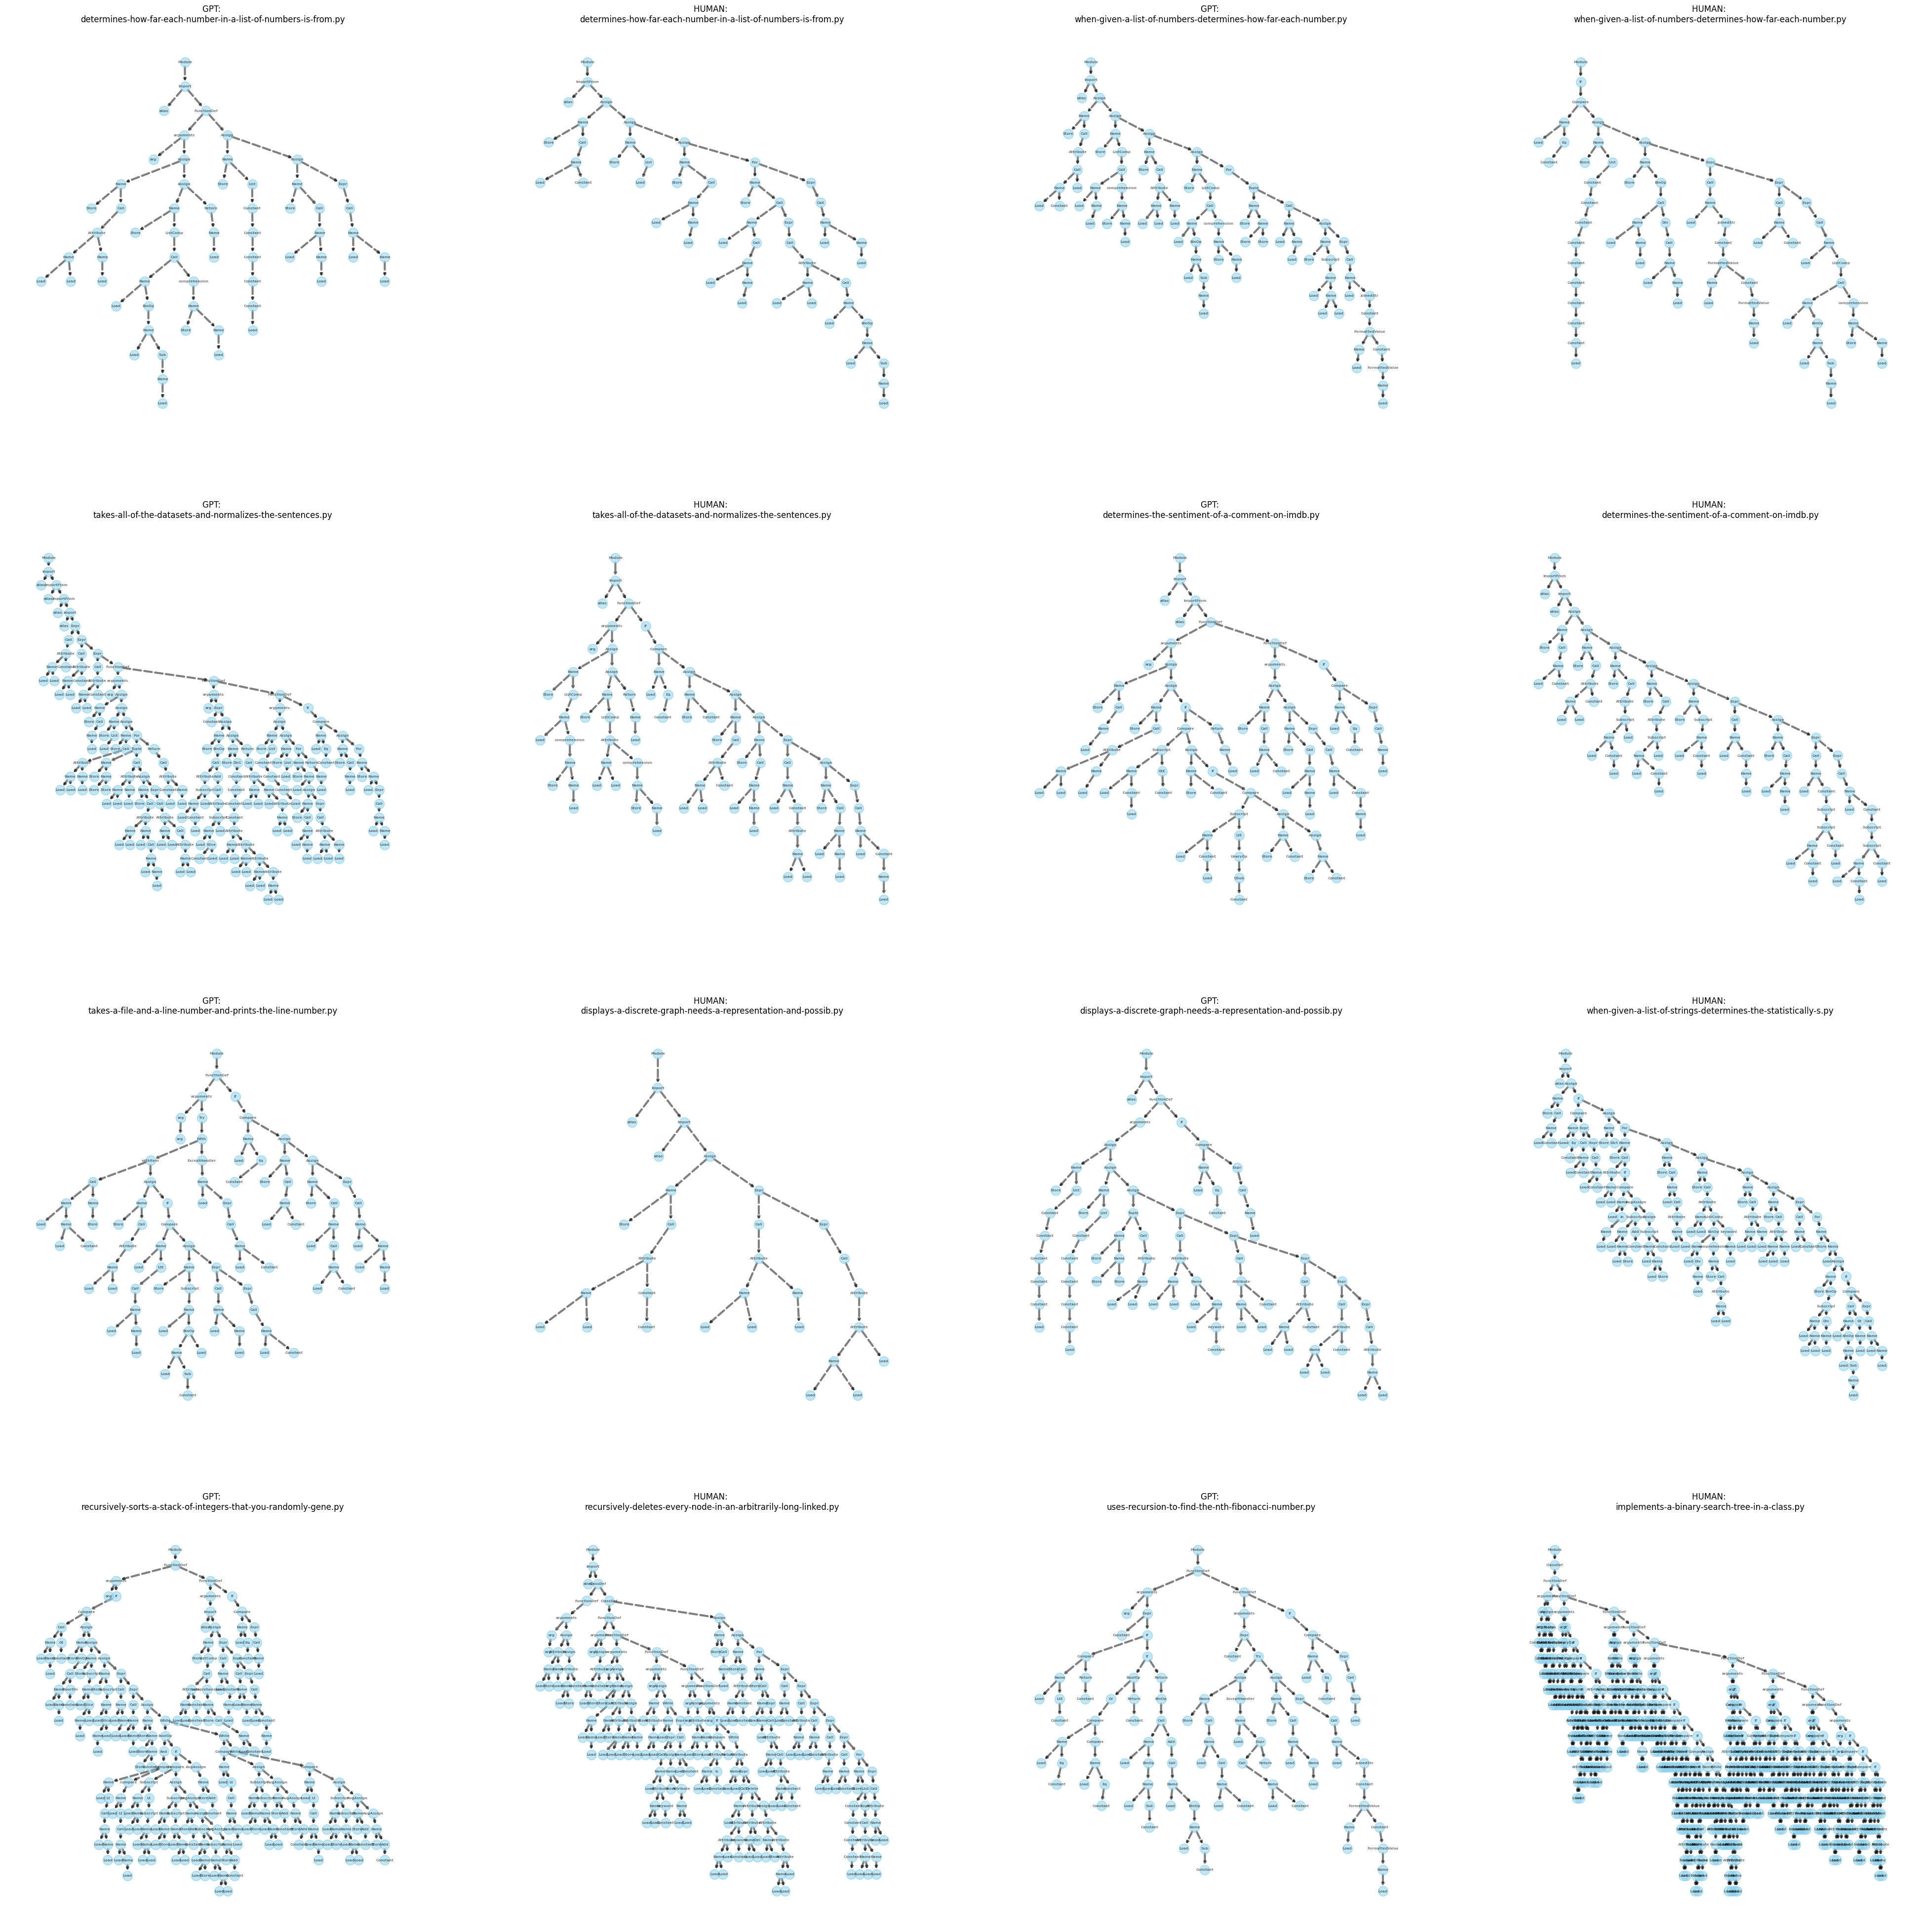

In [160]:
# Visualize some graphs from the ChatGPT dataset
from tqdm import tqdm
fig, ax = plt.subplots(4, 4, figsize=(50, 50))
for i in tqdm(range(0,4)):
    for j in range(0,4,2):
        plot_graph(ChatGPT_ast_graph_df.iloc[i*10+j]['Graph'], label="GPT: \n"+ChatGPT_ast_graph_df.iloc[i*10+j]['Filename'], ax =ax[i][j])
        plot_graph(humanCode_ast_graph_df.iloc[i*10+j]['Graph'], label="HUMAN: \n"+humanCode_ast_graph_df.iloc[i*10+j]['Filename'], ax =ax[i][j+1])